Por Miguel Ángel Castañeda Martínez

Cuando empecé mi trayectoria como científico de datos tenía escaso conocimiento de lenguajes de programación, modelos de aprendizaje de máquina, análisis exploratorio de datos, etc. En un inicio imaginaba que la analítica de datos iba más por el camino de los sistemas, el poder computacional, y los algoritmos, pero nunca imaginé que tuviera algo que ver con estadística. Para mí la estadística era una materia más con la que debía cumplir en la carrera, la veía como algo arcaico y tedioso. Poco me imaginaba en que años después terminaría siendo de mis temas favoritos, que encontraría fascinante el inmenso mundo en el que me adentraría.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import beta

plot_settings = {'title':14, 'text':12, 'annotation':10, 'figsize':(16,8)}

## Enfoque frecuentista

Primero se hace una inspección rápida de las encuestas para identificar variables de interés

In [2]:
poll_data = pd.read_stata('./pew_research_center_june_elect_wknd_data.dta')

Se trabajará únicamente con las variables [`state`, `survey`, `ideo`].

- `state`: Estado en el que se realizaró la encuesta.
- `survey`: Identificador de la encuesta aplicada en cada registro.
- `ideo`: Ideología política del encuestado.

**Paso 1**: Se agrupan los datos por estado para extraer las encuestas que se
aplicaron a cada uno.

In [3]:
state = poll_data.groupby(by='state').count()
state.reset_index(inplace=True)
state = state[['state', 'survey']]

**Paso 2**: Se agrupa por estado e ideología política para poder filtrar a las
encuestas que son _very liberal_.

In [4]:
ideo = poll_data.groupby(by=['state','ideo']).count()
ideo.reset_index(inplace=True)
ideo = ideo[['state', 'ideo', 'survey']]
very_liberal = ideo.loc[ideo['ideo'] == 'very liberal']

**Paso 3**: Se unen los dos conjuntos de datos agrupados.

In [5]:
prop = pd.merge(left=state,
 right=very_liberal,
 how='left',
 on='state',
 suffixes=('_total','_very_lib'))

**Paso 4**: Se crean variables con la proporción de _very liberal_ de máxima verosimilitud para cada estado.

In [6]:
prop['prop_mle'] = prop['survey_very_lib'] / prop['survey_total']
#Se eliminan estados que no son de interés
prop = prop[~prop['state'].isin(['washington dc', 'hawaii', 'alaska'])]
prop.head()

,state,survey_total,ideo,survey_very_lib,prop_mle
0,alabama,624,very liberal,30,0.048077
1,arizona,542,very liberal,28,0.051661
2,arkansas,307,very liberal,7,0.022801
3,california,2854,very liberal,179,0.062719
4,colorado,468,very liberal,27,0.057692


**Paso 5**: Se visualiza el comportamiento del número de encuestas realizadas por estado contra el estimador de máxima verosimilitud.

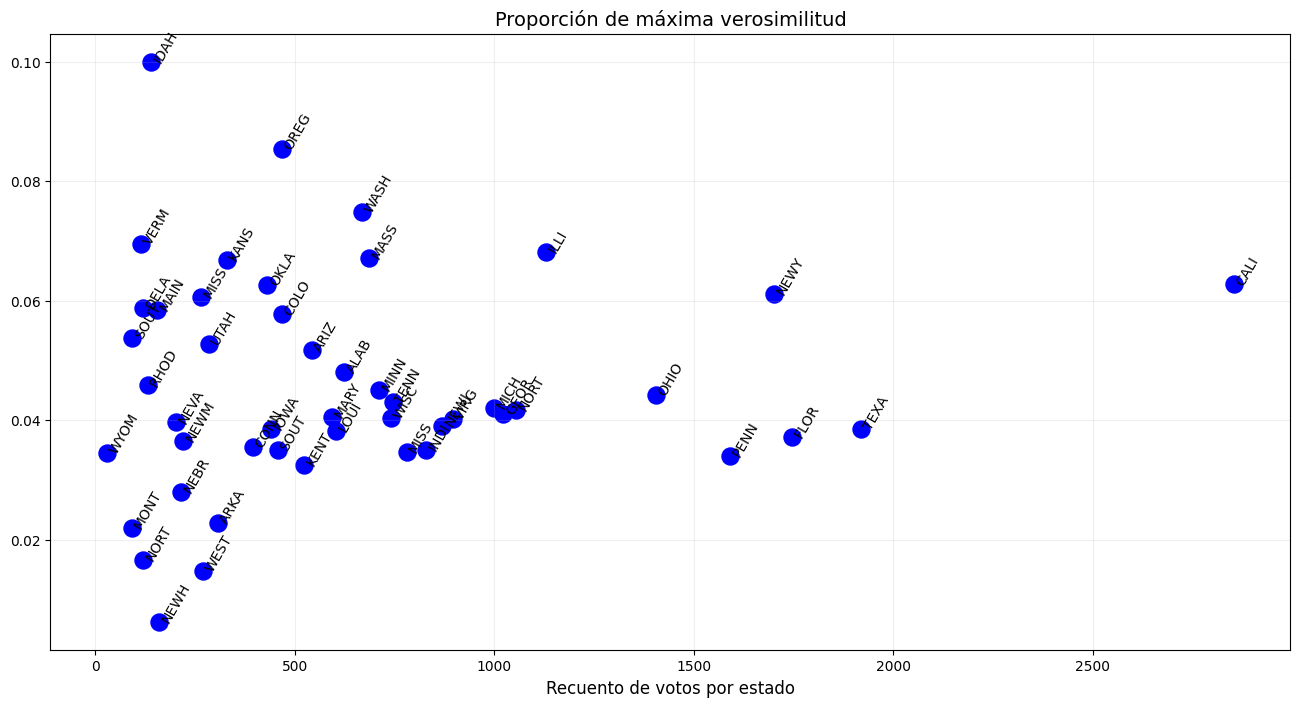

In [7]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], s=150, color='blue')
for idx in prop.index:
    x = prop.loc[idx]['survey_total']
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=plot_settings['annotation'], rotation=60)
plt.title('Proporción de máxima verosimilitud', fontsize=plot_settings['title'])
plt.xlabel('Recuento de votos por estado', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)
plt.show()

Ahora revisamos los datos de la votación real, para lo cual se realizan los siguientes pasos:

**Paso 1**: Se une al conjunto de datos el porcentaje de votos por Obama de cada estado.

In [8]:
results = pd.read_csv('./2008ElectionResult.csv')

#se descartan estados que no son de interés
results = results[~results['state'].isin(['District of Columbia', 'Hawaii', 'Alaska'])]
results['state'] = results['state'].str.lower()

                  
prop = pd.merge(left=prop,
                right=results[['state', 'vote_Obama_pct']],
                how='left',
                on='state')

**Paso 2**: Se comparan los votos de obama con los que son _very liberal_

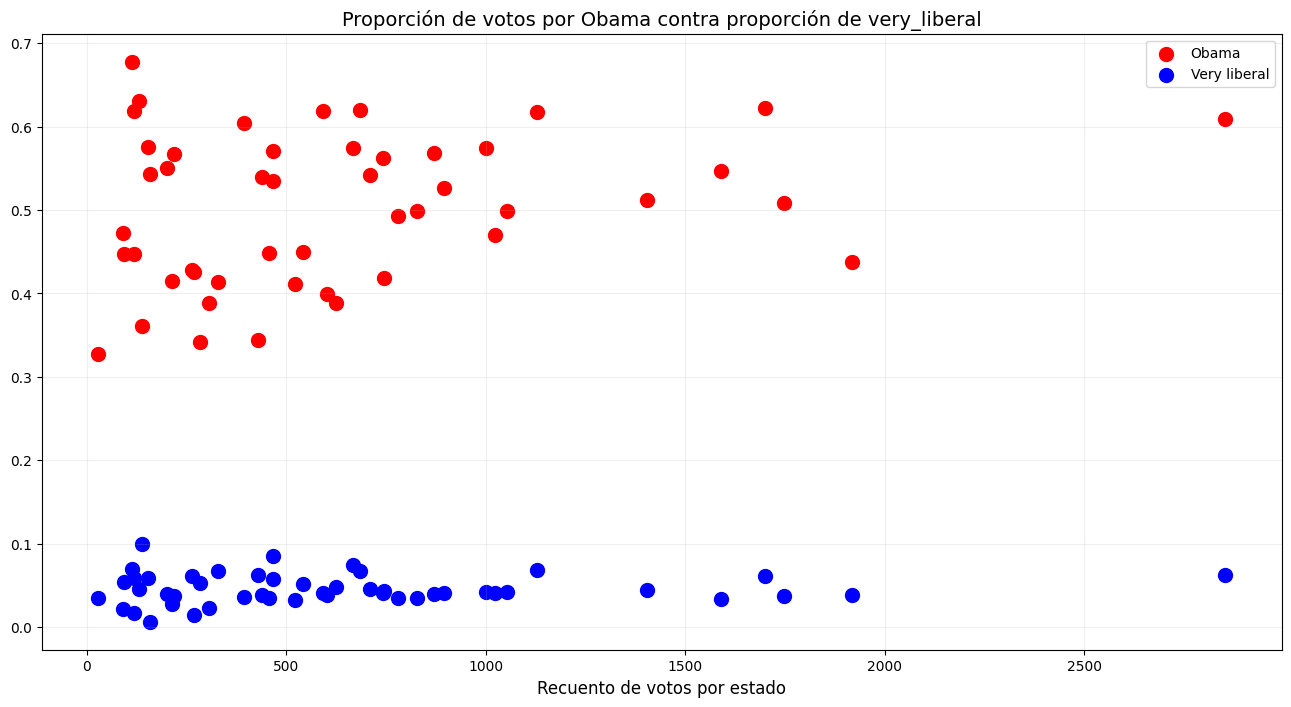

In [9]:
plt.figure(figsize=plot_settings['figsize'])

plt.scatter(x=prop['survey_total'], y=prop['vote_Obama_pct']/100, color='red', s=100, label='Obama')
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='blue', s=100, label='Very liberal')

plt.title('Proporción de votos por Obama contra proporción de very_liberal', fontsize=plot_settings['title'])
plt.xlabel('Recuento de votos por estado', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)
plt.legend(fontsize=plot_settings['annotation'])

plt.show()

Los datos muestran un comportamiento similar en el eje del recuento de votos por estado, sin embargo, el hecho de que se encuentren en escalas diferentes dificulta el poder encontrar algún patrón o similitud entre ambos conjuntos.

Para resolver lo anterior, visualizamos los datos en la misma escala de visual, pero respetando su orden de magintud.

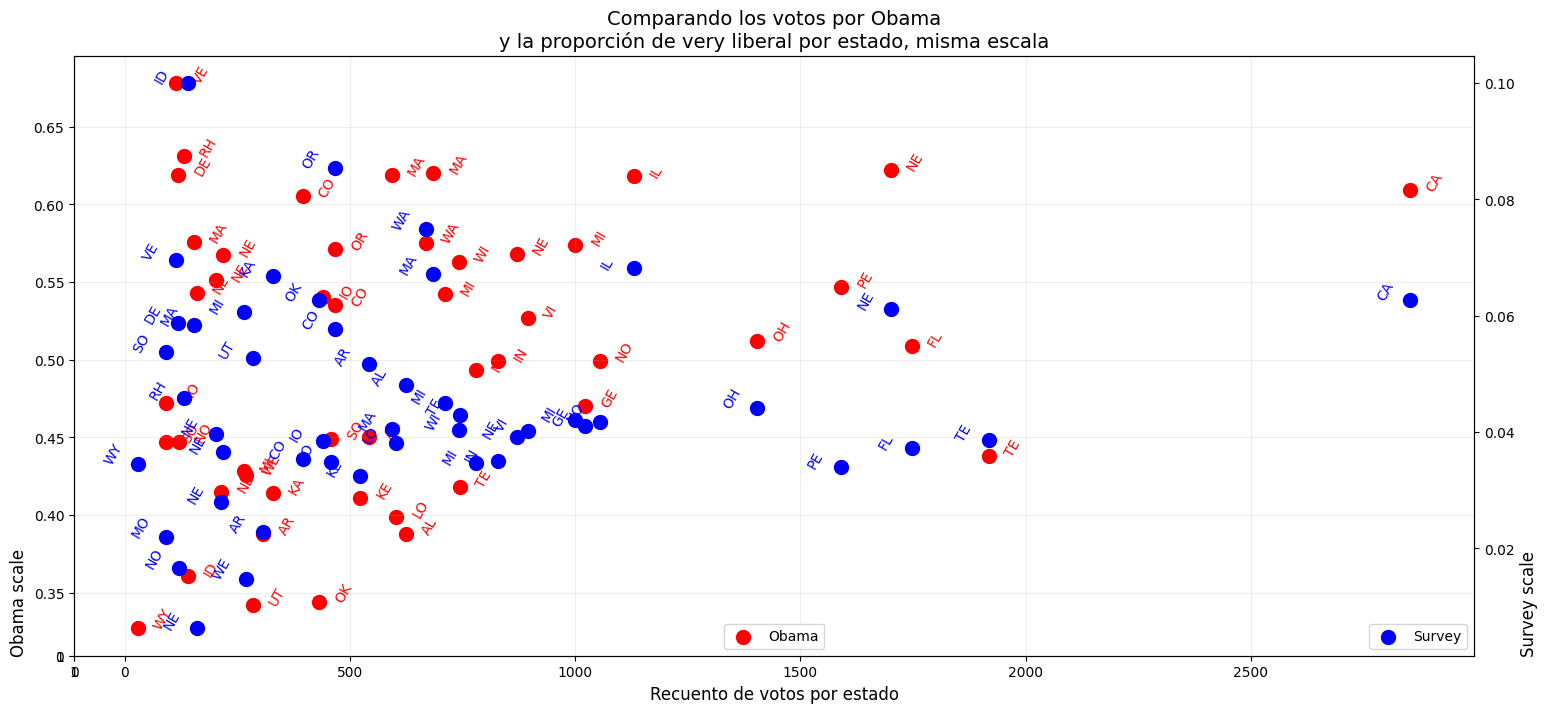

In [10]:
# Plot two lines with different scales on the same plot
fig = plt.figure(figsize=(14,6))
s = 100

#Gráficas
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0, 0, 0, 0]) #
ax2 = ax1.twinx()
lns1 = ax1.scatter(x=prop['survey_total'], y=prop['vote_Obama_pct']/100, color='red', s=s, label='Obama')
lns2 = ax2.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='blue', s=s, label='Survey')

#Anotaciones y estilo
ax1.set_xlabel('Recuento de votos por estado', fontsize=plot_settings['text'])
ax1.set_ylabel('Obama scale', fontsize=plot_settings['text'], loc='bottom')
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Survey scale', fontsize=plot_settings['text'],  loc='bottom')
ax1.legend(loc=8, fontsize=plot_settings['annotation']); ax2.legend(loc=4, fontsize=plot_settings['annotation'])

for idx in prop.index:
    x1 = prop.loc[idx]['survey_total'] + 30
    y1 = prop.loc[idx]['vote_Obama_pct']/100
    s1 = prop.loc[idx]['state'].upper().replace(' ', '')[0:2]
    ax1.text(x=x1, y=y1, s=s1, fontsize=plot_settings['annotation'], rotation=60, color='red')
    
    x2 = prop.loc[idx]['survey_total'] - 80
    y2 = prop.loc[idx]['prop_mle']
    s2 = prop.loc[idx]['state'].upper().replace(' ', '')[0:2]
    ax2.text(x=x2, y=y2, s=s2, fontsize=plot_settings['annotation'], rotation=60, color='blue')
    
plt.title('Comparando los votos por Obama\ny la proporción de very liberal por estado, misma escala', fontsize=plot_settings['title'])
ax1.grid(alpha=0.2)
    
plt.show()

Con la visualización anterior se vuelve evidente que el número de votos que tuvo Obama por estado sigue un patrón sumamente similar a la proporción de personas por estado que se consideran _very liberal_.

Se grafican los votos por Obama contra la proporción de liberales

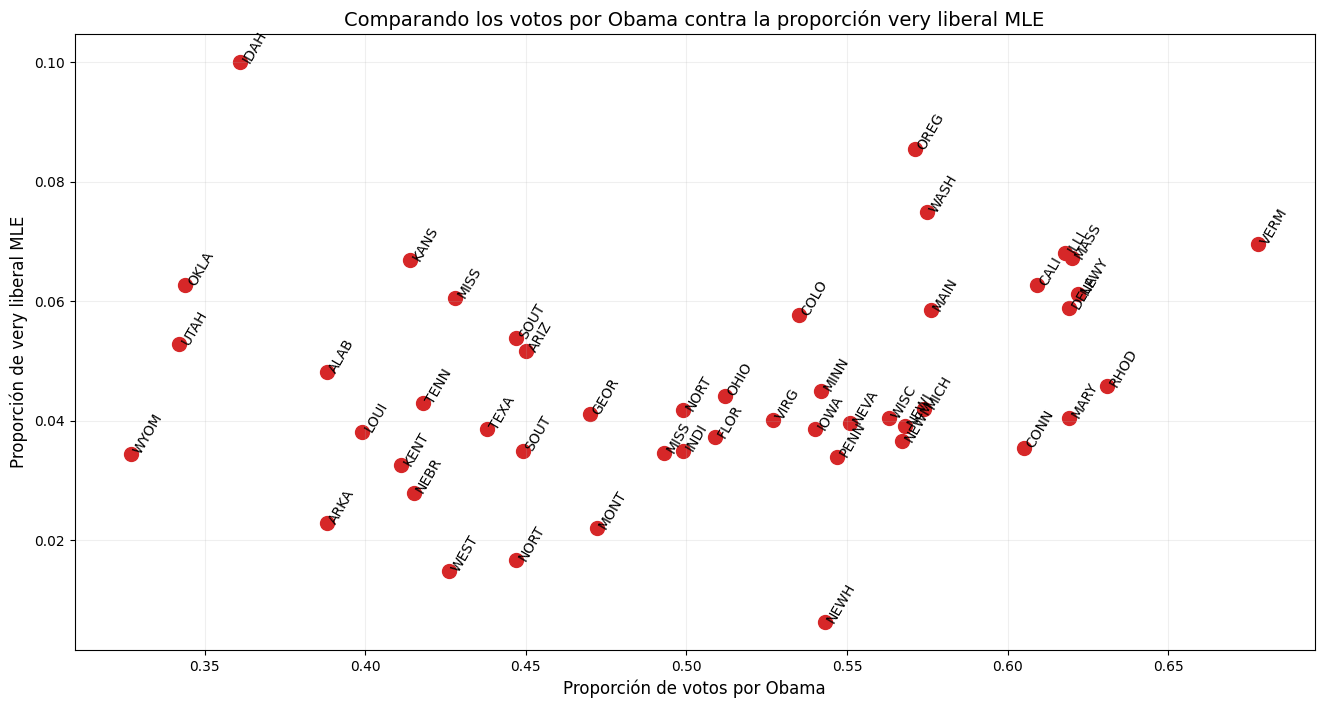

In [11]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_mle'], color='tab:red', s=100)

for idx in prop.index:
    x = prop.loc[idx]['vote_Obama_pct']/100
    y = prop.loc[idx]['prop_mle']
    s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
    plt.text(x=x, y=y, s=s, fontsize=plot_settings['annotation'], rotation=60)

plt.title('Comparando los votos por Obama contra la proporción very liberal MLE', fontsize=plot_settings['title'])
plt.xlabel('Proporción de votos por Obama', fontsize=plot_settings['text'])
plt.ylabel('Proporción de very liberal MLE', fontsize=plot_settings['text'])
plt.grid(alpha=0.2)

plt.show()

En general, del gráfico anterior se ve una ligera tendencia a que Obama tenga una mayor proporción de votantes por estado a medida que la proporción de personas _very liberal_ aumenta.

Esta tendencia se rompe en estados como `IDAH`, `OKLA`, en donde se esperaría que Obama hubiera tenido mayor proporción de votantes; o `NEWH`, en donde se esperaría que no hubiera tenido tantos votos

## Enfoque Bayesiano
**Paso 1**: Generamos una función para calcular los parámetros $a$, $b$ de la inicial dados los valores de $\mu$, $\sigma$.

In [12]:
def get_beta_params(mu, var): 
    a = mu * (-mu**2 + mu - var) / var
    b = (mu - 1) * (mu**2 - mu + var) / var
    return [a, b]

**Paso 2**: Inspeccionamos visualmente el comportamiento de las proporciones por estado.

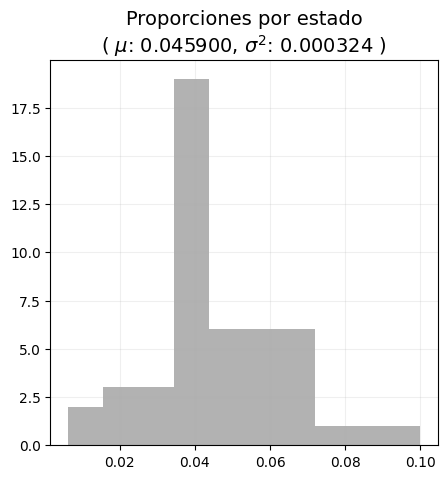

In [13]:
m = prop['prop_mle'].mean()
s2 = prop['prop_mle'].var()

fig, ax = plt.subplots(figsize=(5,5))

plt.hist(x=prop['prop_mle'], color='grey', alpha=0.6)
plt.title(f"Proporciones por estado\n( $\mu$: {m:.6f}, $\sigma^2$: {s2:.6f} )", fontsize=plot_settings['title'])
plt.grid(alpha=0.2)

plt.show()

**Paso 3**: Tomando la media y la varianza de la distribución anterior, obtenemos los valores $a$, $b$ de la distribución inicial.

In [14]:
a, b = get_beta_params(m, s2)

**Paso 4**: Comparamos las iniciales y las posteriores de 9 estados de interés

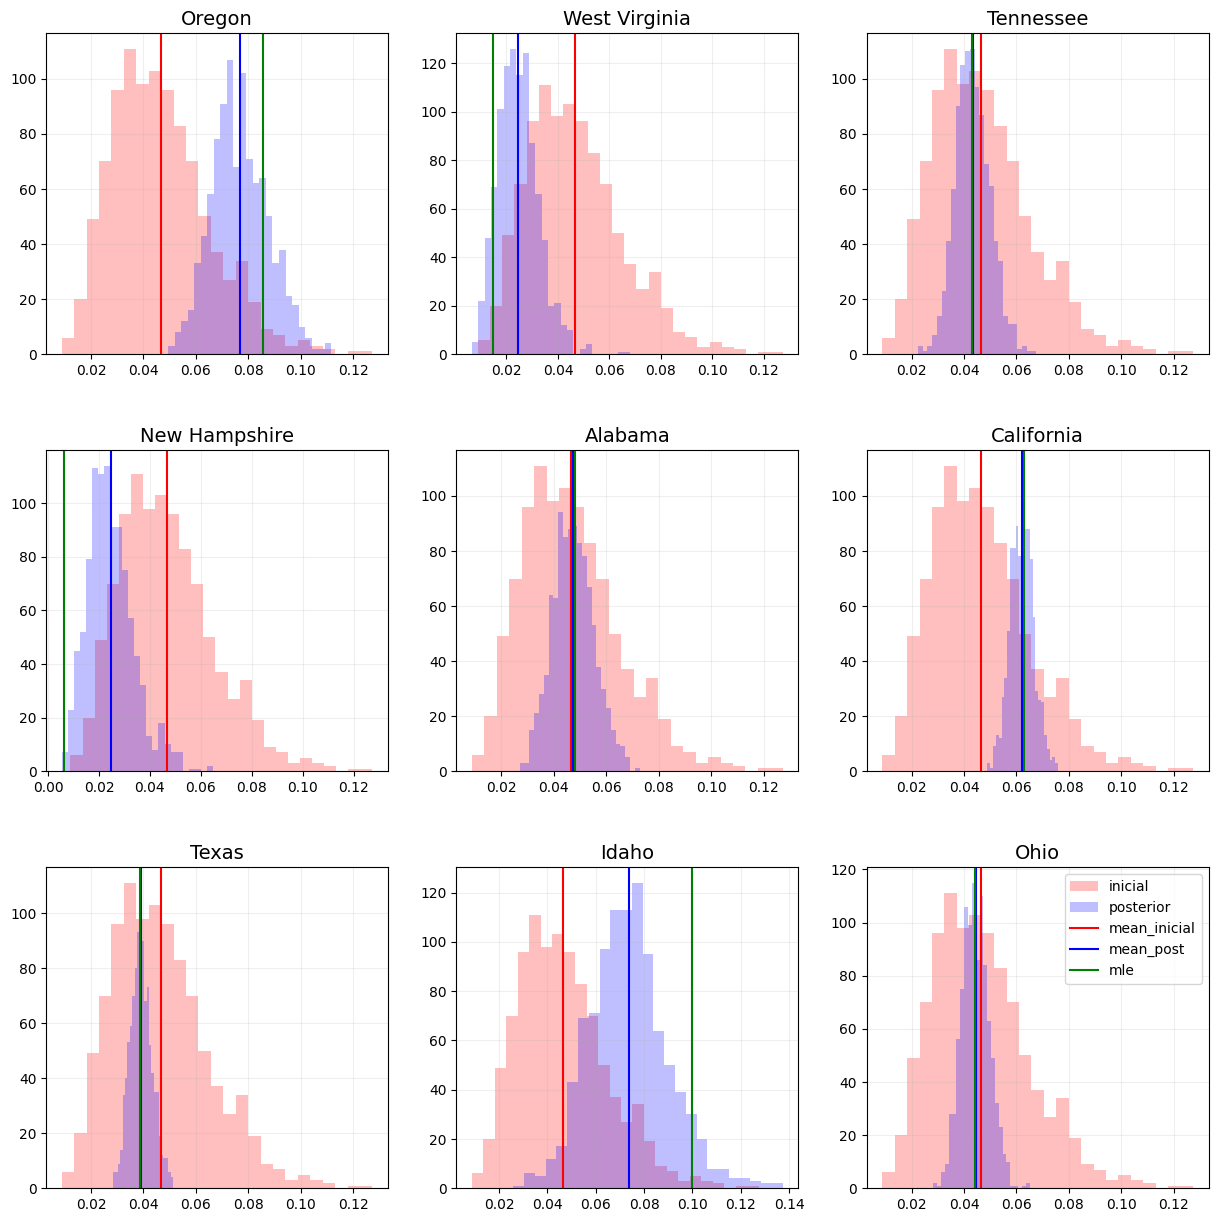

In [15]:
#Parámetros de simulación
sims = 1_000
inicial = beta.rvs(a=a, b=b, size=sims)
inicial_mean = inicial.mean()

#Parámetros de panel
panels = 3
states_idx = [34,45,39,26,0,3,40,9,32]

#Parámetros de figura
fig = plt.figure(figsize=(15,15))
spec = plt.GridSpec(ncols=panels, nrows=panels, hspace=0.3)
k = 0
for idx in states_idx:
    state = prop.loc[idx]['state']
    
    #Cálculo de la posterior
    n = prop.loc[idx]['survey_total']
    x = prop.loc[idx]['survey_very_lib']
    posterior = beta.rvs(a=(a+x), b=(b+n-x), size=sims)
    
    #Gráficas
    ax_n = f"ax{k}"
    ax_n = fig.add_subplot(spec[k])
    ax_n.hist(x=inicial, bins=25, color='red', alpha=0.25, label='inicial')
    ax_n.hist(x=posterior, bins=25, color='blue', alpha=0.25, label='posterior')
    ax_n.axvline(x=inicial.mean(), color='red', label='mean_inicial')
    ax_n.axvline(x=posterior.mean(), color='blue', label='mean_post')
    ax_n.axvline(x=prop.loc[idx]['prop_mle'], color='green', label='mle')
    
    #Anotaciones y estilo
    ax_n.set_title(state.title(), fontsize=14)
    ax_n.set_xlabel('')
    ax_n.grid(alpha=0.2)
    
    k += 1
#Anotaciones generales.
plt.legend()
    
plt.show()

La relevancia del panel anterior radica en que se puede ver con claridad el efecto de la verosimilitud de cada estado en la distribución inicial. Al considerar la misma inicial para todos los estados se está modelando el comportamiento promedio del país sobre cada uno de los estados. Sin embargo, al haber modelado la verosimilitud de cada estado de manera independiente, se puede ver que la posterior de cada uno tiene comportamientos distintos dependiendo de varios posibles factores, por ejemplo:
* Si la verosimilitud está por debajo de la inicial, entonces la posterior se mueve hacia la izquierda.
* Por el contrario, si la verismilitud es mayor a la inicial entonces la posterior se recorre hacia la derecha.
* Si se trata de un estado con poca represantación en las encuestas, entonces la inicial domina sobre la verosimilitud y vicecersa.
* Finalmente, en todos los casos se satisface que la posterior es un punto intermedio entre la inicial y la verosimilitud.

Obtenemos el estimador de la posterior para todos los estados

In [16]:
#Se crea columna vacía en dataframe
prop['prop_bayes'] = np.nan

for idx in prop.index:
    #Cálculo de la posterior
    n = prop.loc[idx]['survey_total']
    x = prop.loc[idx]['survey_very_lib']
    posterior_mean = beta.rvs(a=(a+x), b=(b+n-x), size=sims).mean()
    
    prop.loc[prop.index == idx, 'prop_bayes'] = posterior_mean

Comparamos el desplazamiento del estimador MLE provocado por la distribucón inicial bajo un enfoque bayesiano

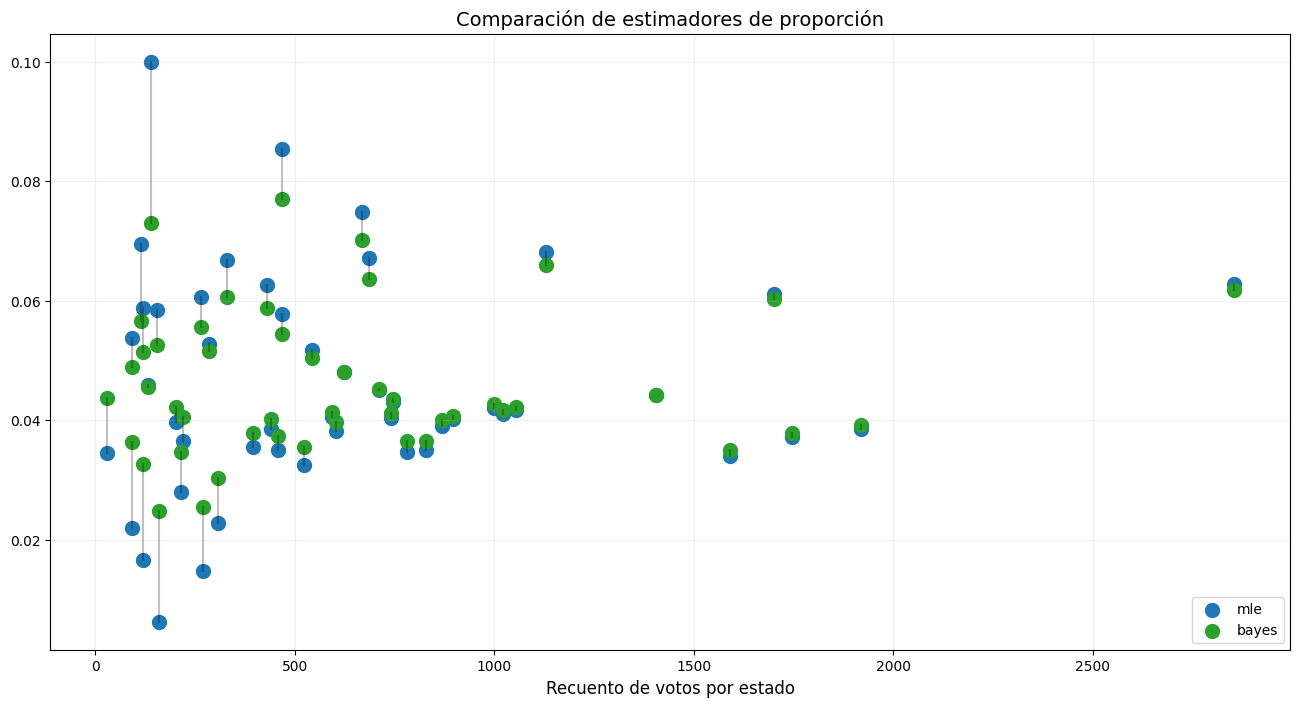

In [17]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], color='tab:blue', s=100, label='mle')
plt.scatter(x=prop['survey_total'], y=prop['prop_bayes'], color='tab:green', s=100, label='bayes')

for idx in prop.index:
    x = prop.loc[idx]['survey_total']
    y_mle = prop.loc[idx]['prop_mle']
    y_bayes = prop.loc[idx]['prop_bayes']
    plt.plot([x,x], [y_mle, y_bayes], color='black', alpha=0.25)

plt.title('Comparación de estimadores de proporción', fontsize=plot_settings['title'])
plt.xlabel('Recuento de votos por estado', fontsize=plot_settings['text'])
plt.legend(fontsize=plot_settings['annotation'], loc=4)
plt.grid(alpha=0.2)

plt.show()

Nuevamente graficamos la proporción de votos que tuvo obama contra la proporción de _very liberal_ por estado, en esta ocasión con los resultados del enfoque bayesiano.

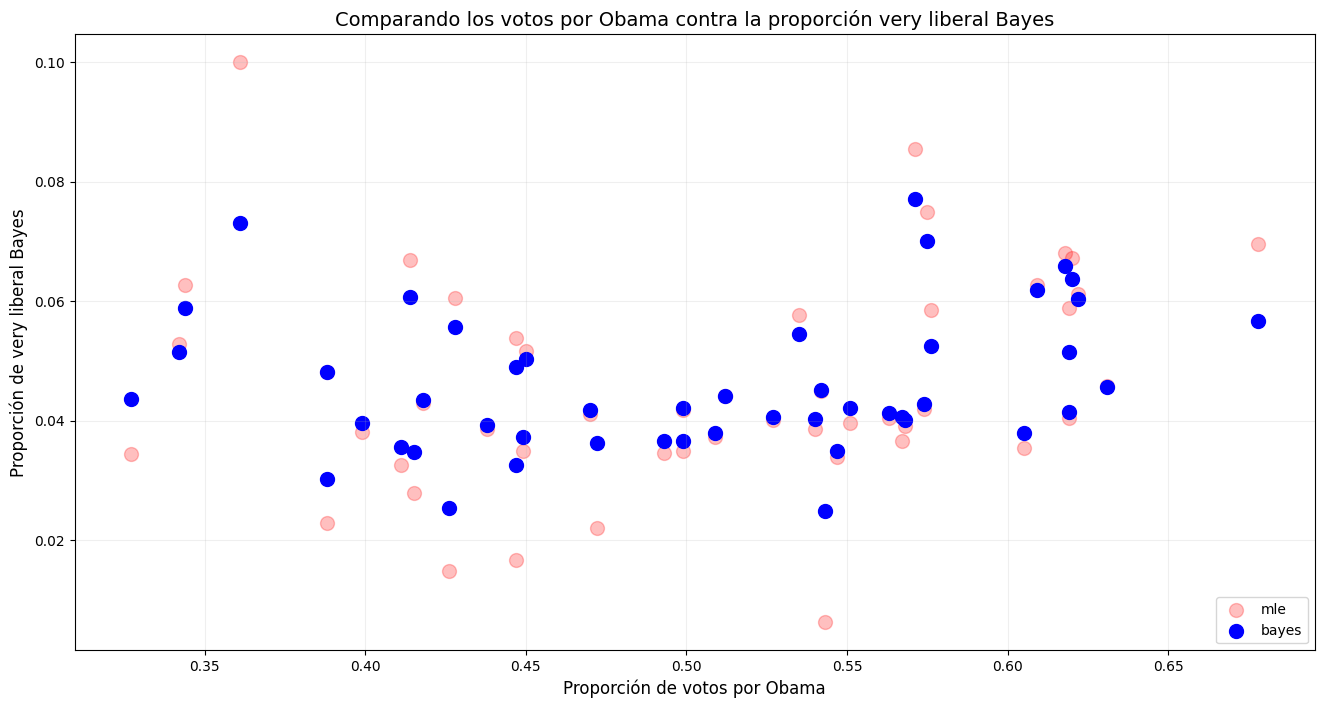

In [18]:
plt.figure(figsize=plot_settings['figsize'])
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_mle'], color='red', s=100, label='mle', alpha=0.25)
plt.scatter(x=prop['vote_Obama_pct']/100, y=prop['prop_bayes'], color='blue', s=100, label='bayes')

plt.title('Comparando los votos por Obama contra la proporción very liberal Bayes', fontsize=plot_settings['title'])
plt.xlabel('Proporción de votos por Obama', fontsize=plot_settings['text'])
plt.ylabel('Proporción de very liberal Bayes', fontsize=plot_settings['text'])
plt.legend(fontsize=plot_settings['annotation'], loc=4)
plt.grid(alpha=0.2)

plt.show()

* Lo primero que notamos es que bajo este enfoque se reduce la dispersión de los puntos, manifestando un comportamiento relativamente más lineal que con el enfoque frecuentista.
* Adicionalmente, se mantiene la tendencia de que a mayor proporción de _very liberal_ en el estado mayor proporción de votos por Obama. Sin embargo, si bien la tendencia se mantiene la pendiente disminuye por la menor dispersión en los datos.

## Anexo 1
Utilizando el paquete de python `sympy` para cálculo simbólico, se obtuvieron las ecuaciones que resulven los parámetros $a$, $b$ de una distribución conjugada beta-binomial dados los valores de $\mu$, $\sigma$.

In [19]:
from sympy import symbols, Eq, solve
from sympy.abc import mu, sigma

In [20]:
a, b, s2, m = symbols("a b sigma^2 mu")

equation_1 = Eq( a / (a+b), m )
equation_2 = Eq( a*b / ((a+b)**2 * (a + b + 1)), s2 )
solution = solve((equation_1, equation_2), (a, b))

In [21]:
equation_1

Eq(a/(a + b), mu)

In [22]:
equation_2

Eq(a*b/((a + b)**2*(a + b + 1)), sigma^2)

In [23]:
print("Solución para el parámetro 'a':\n")
solution[0][0]

Solución para el parámetro 'a':



mu*(-mu**2 + mu - sigma^2)/sigma^2

In [24]:
print("Solución para el parámetro 'b':\n")
solution[0][1]

Solución para el parámetro 'b':



(mu - 1)*(mu**2 - mu + sigma^2)/sigma^2

Las expresiones anteriores se puegen programar directamente en una función de python

---